# RSS News Feeds Analysis Notebook

This notebook pulls multiple RSS feeds, aggregates the data, and performs basic analysis and visualization.  
To gather a dataset, we plan to use a github action that every will run and store the news a json.  
This will allow us to compare and analyze trend in the medias.

In [2]:
%pip install feedparser pandas matplotlib scikit-learn seaborn nltk bertopic

  Using cached feedparser-6.0.11-py3-none-any.whl.metadata (2.4 kB)
  Using cached sgmllib3k-1.0.0-py3-none-any.whl
  Using cached hdbscan-0.8.40-cp312-cp312-linux_x86_64.whl
  Using cached sentence_transformers-3.4.1-py3-none-any.whl.metadata (10 kB)
  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached torch-2.6.0-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-n

In [3]:
import feedparser
import pandas as pd
import matplotlib.pyplot as plt

# List your RSS feed URLs here
feed_urls = [
    "https://feeds.bbci.co.uk/news/rss.xml",
    "https://reutersbest.com/feed/",
    "https://www.euronews.com/rss",
    "https://www.wired.com/feed/rss",
    "https://news.google.com/rss?hl=en-US&gl=US&ceid=US:en",
    "https://rss.nytimes.com/services/xml/rss/nyt/HomePage.xml"

]

# List to hold all the feed entries
entries = []

# Pull and parse each feed
for url in feed_urls:
    try:
        feed = feedparser.parse(url)
        if 'title' not in feed.feed:
            print(f"Skipping feed {url} as it does not contain a title.")
            continue
        source_title = feed.feed.get('title', 'Unknown Source')
        for entry in feed.entries:
            entries.append({
                'source': source_title,
                'title': entry.get('title', ''),
                'published': entry.get('published', entry.get('updated', entry.get('pubDate', ''))),
                'link': entry.get('link', ''),
                'summary': entry.get('summary', entry.get('description', ''))
            })
    except Exception as e:
        print(f"Error parsing feed {url}: {e}")

# Create a DataFrame from the entries
df = pd.DataFrame(entries)

# Convert the published date to a datetime object, handling errors gracefully
df['published'] = pd.to_datetime(df['published'], errors='coerce')

# Display a sample of the data
print('Sample entries:')
display(df.head())

Skipping feed https://www.euronews.com/rss as it does not contain a title.
Sample entries:


,source,title,published,link,summary
0,BBC News,Counter-terror police lead fire investigation,2025-03-21 14:26:46,https://www.bbc.com/news/articles/cvg5dg4p2l0o,"The Met says there is ""currently no indication..."
1,BBC News,What happened and when will the airport reopen?,2025-03-21 14:26:32,https://www.bbc.com/news/articles/c1jp1dg7g45o,Flights around the world are facing disruption...
2,BBC News,What are my rights if my flight is cancelled?,2025-03-21 11:49:46,https://www.bbc.com/news/articles/cwyde870y89o,What are you entitled to if your flight is can...
3,BBC News,'We don't know what's happening next - it's ch...,2025-03-21 14:55:30,https://www.bbc.com/news/articles/cx2gd5091x7o,Travellers are grappling with cancelled flight...
4,BBC News,Watch: Acrid smoke and empty runways - the sce...,2025-03-21 10:04:16,https://www.bbc.com/news/videos/c0mw7v1011eo,The BBC's Charlotte Gallagher reports from Hea...


## Basic Analysis and Statistics

We now perform some basic analysis on the aggregated data.

News count per source:


source
WIRED                        50
Top stories - Google News    38
BBC News                     31
NYT > Top Stories            26
Reuters Best                 12
Name: count, dtype: int64

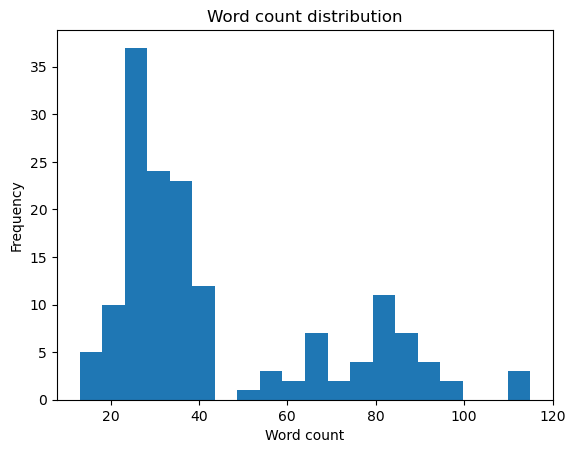

In [4]:
# 1. Count of news items per source
news_count = df['source'].value_counts()
print('News count per source:')
display(news_count)

# Extract the words count of each news, the title and the summary
df['word_count'] = df['title'].str.split().str.len()
df['word_count'] = df['summary'].str.split().str.len() + df['word_count']
# visualize the word count
df['word_count'].plot(kind='hist', bins=20)
plt.title('Word count distribution')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.show()



## Visualizations

- A bar chart showing the number of news items per source.

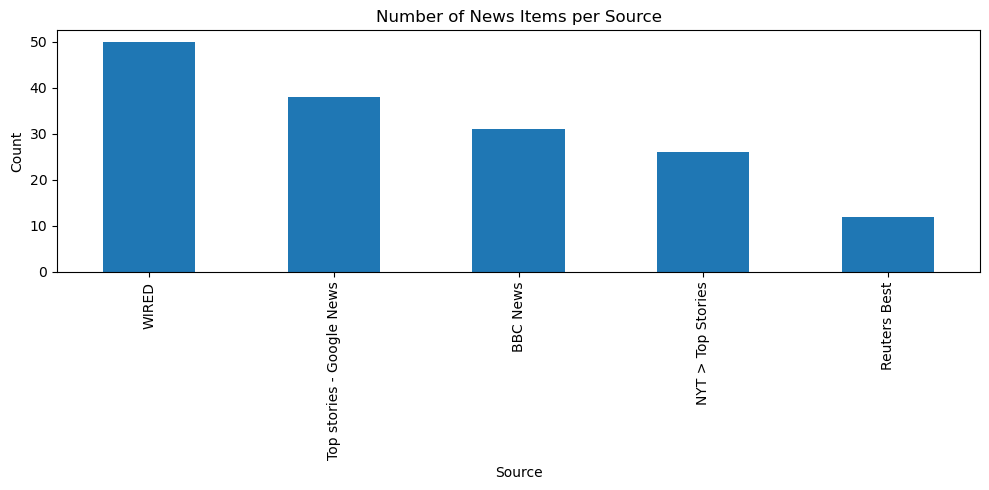

In [5]:
# Plot: Number of News Items per Source
plt.figure(figsize=(10, 5))
news_count.plot(kind='bar')
plt.title('Number of News Items per Source')
plt.xlabel('Source')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [6]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


Next, let's look at the similarity between each article descriptions using cosine similarity.  
This may give us insight in how article each relate to each others.
 


[nltk_data] Downloading package stopwords to /home/dino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


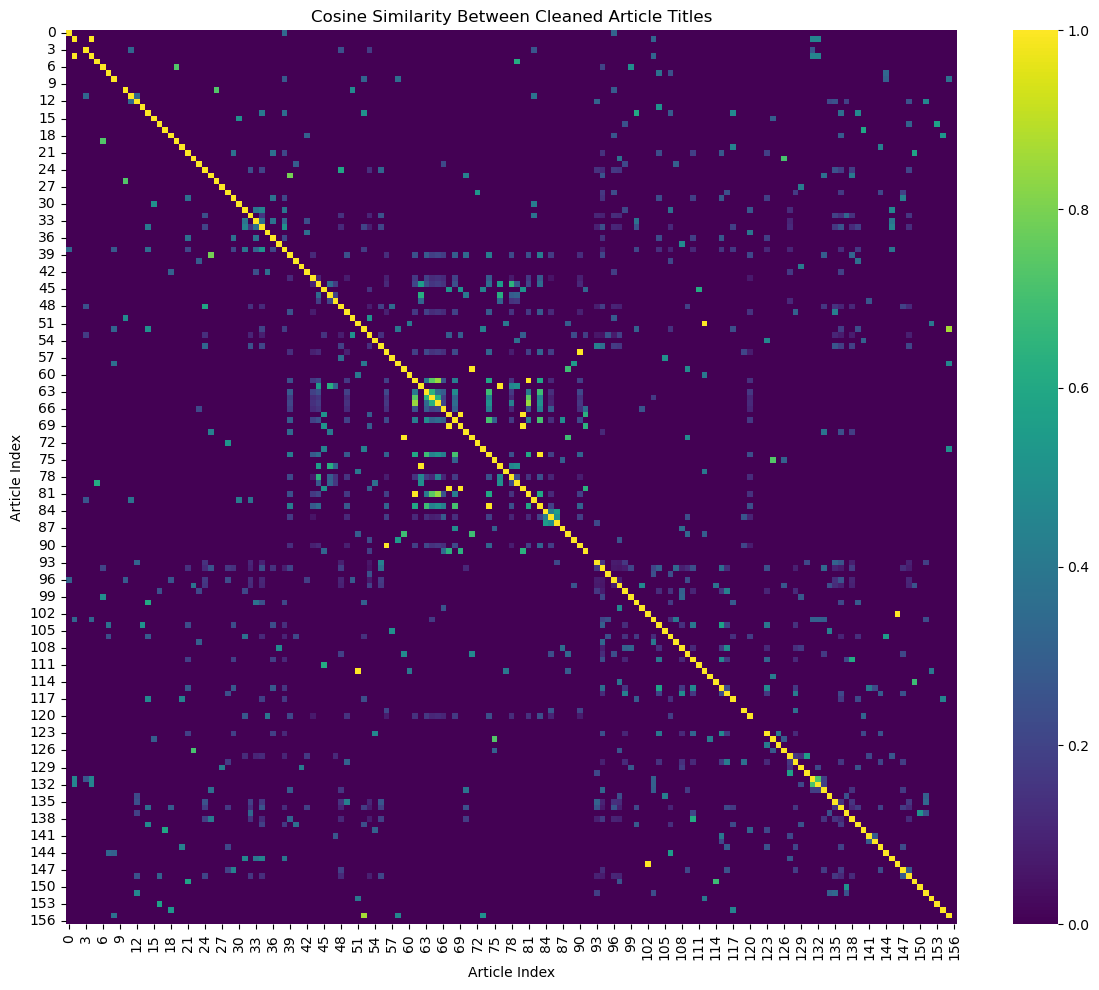

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already
nltk.download('stopwords')

# Prepare English stopwords
stop_words = set(stopwords.words('english'))

# Drop duplicates and null titles
df_titles = df[['title']].dropna().drop_duplicates().reset_index(drop=True)

# Basic text cleaning function
def preprocess(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and lowercase
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

df_titles['tokens'] = df_titles['title'].apply(preprocess)

# Flatten list of tokens to get word frequencies
all_tokens = [token for sublist in df_titles['tokens'] for token in sublist]
token_freq = Counter(all_tokens)

# Filter out infrequent words
df_titles['filtered_tokens'] = df_titles['tokens'].apply(
    lambda tokens: [t for t in tokens if token_freq[t] > 1]
)

# Convert token lists back to strings
df_titles['cleaned_title'] = df_titles['filtered_tokens'].apply(lambda tokens: ' '.join(tokens))

# TF-IDF Vectorization on cleaned titles
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_titles['cleaned_title'])

# Compute similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix)

# Plot the similarity heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cosine_sim, cmap='viridis')
plt.title("Cosine Similarity Between Cleaned Article Titles")
plt.xlabel("Article Index")
plt.ylabel("Article Index")
plt.tight_layout()
plt.show()


The results can be disappointing but are not unexpected, as news outlets often use varied wording.
To address this, we can use an embedding model to capture the underlying meaning of the texts
There a neat library [BERTopic](https://maartengr.github.io/BERTopic/index.html) to do so simply.  
Here is sneak peak of what it can do : 

In [14]:
from bertopic import BERTopic

titles = df_titles['title']

# Create and fit BERTopic model
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(titles)


2025-03-21 16:09:03,180 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

2025-03-21 16:09:04,451 - BERTopic - Embedding - Completed ✓
2025-03-21 16:09:04,451 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-21 16:09:04,625 - BERTopic - Dimensionality - Completed ✓
2025-03-21 16:09:04,626 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-21 16:09:04,632 - BERTopic - Cluster - Completed ✓
2025-03-21 16:09:04,634 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-21 16:09:04,642 - BERTopic - Representation - Completed ✓


In [15]:
topic_model.visualize_topics()

In [16]:
topic_model.visualize_heatmap()